In [1]:
# This directive tells the notebook to add interactive plots in the notebook
#%matplotlib# widget
#%matplotlib

from model.solver import Solver #bm3_barotropic_model packages
from model.sphere import Sphere
from utils import constants, plotting, parcel_tracking, animations
import ensemble_methods as em
from cython_routines import bm_methods as cbm

import time
import numpy as np
import random
import xarray as xr

import matplotlib.pyplot as plt    

from tqdm import tqdm
from importlib import reload
from IPython.display import display, clear_output, HTML, FileLink  # Some technical stuff, used to display animation

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
st = Sphere(base_state='solid') #initialize model state

#add particular model params for this ensemble...look at utils/config for some ideas of defaults
params=dict(nu=0, tau = 0, diffusion_order=4, dt=1800, vort_linear=False, theta_linear=False,
            ensemble_size = 20, forcing_type='rededdy', ofreq=8, ICE_JUMP=10, ICE_LAT=60, ICE_WIDTH=1)

params['seaice']=True # add a sea ice field

T=14*constants.day2sec #total integration time

ensemble = em.integrate_ensemble(st=st, T=T, **params)

100%|███████████████████████████████████████████| 20/20 [01:12<00:00,  3.60s/it]


In [3]:
#we'll pick the point with max variance at the end of the simulation and track parcels to their origin
reload(parcel_tracking)
std = ensemble.theta.std('ens_mem').sel(y=slice(30,90)).isel(time=-1)
sm = std.where(std==std.max(), drop=True).squeeze()
x0 = [(sm.x.item(0),sm.y.item(0))]# x0 should be in form [(lon,lat),]

#we'll just track 10 ensemble mem. trajectories, otherwise it takes a bit
ts, xs = parcel_tracking.ens_calculate_trajectories(ensemble.sel(ens_mem=slice(0,10)), x0, t0 = float(T), rvs=True)

Integrating 1 trajectories for [1209600.].


100%|███████████████████████████████████████████| 41/41 [00:45<00:00,  1.11s/it]

Completed 42 of 42 timesteps.


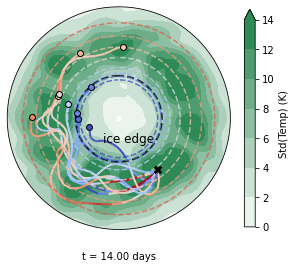

In [5]:
reload(plotting)
plotting.plot_theta_ensspread(ensemble,t=T,trjs=xs,ts=ts, levels=np.arange(0,16,2))
plt.show()

#animation
#plotting.animate_thetaens(ensemble,times = [0,T],xs=xs,ts=ts, tlevs=np.arange(0,9,1))

In [ ]:
####
# below is for bimodal detection, still a WIP
####
ensemble_ss = ensemble.sel(y=slice(0,90)).theta[:,1:]

bm_results, deltas = cbm.apply_find_bimodality(ensemble_ss.values)
bm_results = np.array(bm_results)
deltas = np.array(deltas)


# Get dimensions and coordinates from ensemble
dims = [dim for dim in ensemble_ss.dims if dim != 'ens_mem']
coords = {dim: ensemble_ss[dim].values for dim in dims}
#print(coords)
# Create xarray DataArrays with the same dimensions and coordinates as ensemble
bm_results_xr = xr.DataArray(bm_results, dims=dims, coords=coords)
deltas_xr = xr.DataArray(deltas, dims=dims, coords=coords)

# Combine the DataArrays into a single Dataset
bmxr = xr.Dataset({'bm_results': bm_results_xr, 'deltas': deltas_xr})

In [ ]:
bmxr.bm_results.mean(['x']).plot(vmin=0.05, vmax=0.2)
plt.show()

ensemble.theta.std('ens_mem').mean('x').plot()
plt.show()

In [ ]:
bm = bmxr.bm_results
deltas = bmxr.deltas

indices = np.argwhere( (bm.values==True))
random_index = indices[np.random.choice(indices.shape[0])]
print(random_index)
index_dict = {dim: idx for dim, idx in zip(bm.dims, random_index)}

# Convert the random_index to coordinate labels
coord_labels = {dim: ensemble_ss.coords[dim].isel({dim: idx}).item() for dim, idx in zip(bm.dims, random_index)}

selected_data = ensemble_ss.isel(index_dict)
selected_data.plot.hist(bins=20)
#[plt.axvline(i) for i in Ms.isel(index_dict).values]
plt.show()

hist2ddims = ['run','x']
bm.mean(hist2ddims).plot.contourf(levels = np.arange(0.025,0.115,0.01))

# Determine the remaining dimensions that weren't used in the mean calculation
remaining_dims = [dim for dim in bm.dims if dim not in hist2ddims]

# Add a scatter point using the remaining dimensions from bm.isel(index_dict)
plt.scatter(bm.isel(index_dict)[remaining_dims[1]], bm.isel(index_dict)[remaining_dims[0]], color='red')
#add scatter point onto the hist2ddims plot, where we use whatever two dimensions weren't on bm.mean() from bm.isel(index_dict)
plt.show()
